In [6]:
!pip install transformers --q

!pip install torch

!pip install nltk

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_model.to(device)
finbert_model.eval()  # Set to eval mode
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def finbert_analyze(text):
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = finbert_model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()[0]
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=0).numpy()
    labels = ['neutral', 'positive', 'negative']  # FinBERT's label order
    sentiment = labels[np.argmax(probs)]
    return {
        "sentiment": sentiment,
        "probabilities": dict(zip(labels, probs.round(4)))
    }

sentences = [
    "Apple stock is expected to rise after strong earnings.",
    "The company reported a significant loss this quarter.",
    "Market conditions remain uncertain."
]

for s in sentences:
    print(s, "->", finbert_analyze(s))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Apple stock is expected to rise after strong earnings. -> {'sentiment': 'positive', 'probabilities': {'neutral': 0.0, 'positive': 1.0, 'negative': 0.0}}
The company reported a significant loss this quarter. -> {'sentiment': 'negative', 'probabilities': {'neutral': 0.0, 'positive': 0.0, 'negative': 1.0}}
Market conditions remain uncertain. -> {'sentiment': 'negative', 'probabilities': {'neutral': 0.0016, 'positive': 0.0, 'negative': 0.9983}}


In [23]:
df = pd.read_csv("../sp500_news/aapl_news.csv") 

In [11]:
import pandas as pd
import re
import torch
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize

# FinBERT ön koşulu: tokenizer ve model yüklenmeli
from transformers import AutoTokenizer, AutoModelForSequenceClassification

finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_model.to(device)

# Veri dosyasını oku
df = pd.read_csv("./msft_news_from_html.csv")  # yolunu ihtiyaca göre değiştir

# FinBERT analiz fonksiyonu
def finbert_analyze(text):
    if not isinstance(text, str) or not text.strip():
        return {"sentiment": "neutral", "probabilities": {"neutral": 1.0, "positive": 0.0, "negative": 0.0}}

    inputs = finbert_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = finbert_model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()[0]
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=0).numpy()

    labels = ['neutral', 'positive', 'negative']
    sentiment = labels[np.argmax(probs)]
    return {
        "sentiment": sentiment,
        "probabilities": dict(zip(labels, probs.round(4)))
    }

# Sadece ilgili ticker geçen cümleleri al
def extract_ticker_sentences(text, ticker, company_names=None):
    if not isinstance(text, str) or not text.strip():
        return ""
    patterns = [rf"\b{ticker}\b"]
    if company_names:
        patterns += [re.escape(name) for name in company_names]
    pattern = re.compile("|".join(patterns), re.IGNORECASE)
    sentences = sent_tokenize(text)
    filtered = [s for s in sentences if pattern.search(s)]
    return " ".join(filtered) if filtered else ""

# Satır bazlı analiz fonksiyonu
def analyze_full_row_ticker(row, ticker, company_names=None):
    head_text = extract_ticker_sentences(row['headline'], ticker, company_names)
    desc_text = extract_ticker_sentences(row['description'], ticker, company_names)
    detail_text = extract_ticker_sentences(row['detailed_news'], ticker, company_names)

    head_result = finbert_analyze(head_text)
    desc_result = finbert_analyze(desc_text)
    detail_result = finbert_analyze(detail_text)

    head_probs = head_result['probabilities']
    desc_probs = desc_result['probabilities']
    detail_probs = detail_result['probabilities']

    return pd.Series({
        "headline_positive": head_probs['positive'],
        "headline_neutral": head_probs['neutral'],
        "headline_negative": head_probs['negative'],
        "description_positive": desc_probs['positive'],
        "description_neutral": desc_probs['neutral'],
        "description_negative": desc_probs['negative'],
        "detailed_positive": detail_probs['positive'],
        "detailed_neutral": detail_probs['neutral'],
        "detailed_negative": detail_probs['negative'],
    })

# Örnek: MSFT için
ticker = "MSFT"
company_names = ["Microsoft"]

probs_df = df.apply(lambda row: analyze_full_row_ticker(row, ticker, company_names), axis=1)
df_with_probs = pd.concat([df, probs_df], axis=1)
df_with_probs.head()


,headline,description,link,source,original,related,date_published,date_modified,timezone,detailed_news,headline_positive,headline_neutral,headline_negative,description_positive,description_neutral,description_negative,detailed_positive,detailed_neutral,detailed_negative
0,How Microsoft plays both 'offense and defense',Microsoft's (MSFT) recent climb is a result of...,https://finance.yahoo.com/video/microsoft-play...,NaN,MSFT,[],2025-06-13T15:17:50.000Z,NaN,NaN,Microsoft's (MSFT) recent climb is a result of...,0.8286,0.1711,0.0003,1.0000,0.0000,0.0,0.0166,0.9265,0.0569
1,The 2025 stock market rally is about more than...,After two years of few S&P 500 companies outpe...,https://finance.yahoo.com/news/the-2025-stock-...,NaN,MSFT,"['AAPL', 'PLTR', 'META']",2025-06-13T10:00:42.000Z,NaN,NaN,This is The Takeaway from today's Morning Brie...,0.0000,1.0000,0.0000,0.0000,1.0000,0.0,0.0001,0.1047,0.8952
2,Analysis-Meta's $14.8 billion Scale AI deal la...,(Reuters) -Facebook owner Meta's $14.8 billion...,https://finance.yahoo.com/news/analysis-metas-...,NaN,MSFT,"['META', 'GOOG']",2025-06-13T21:59:26.000Z,NaN,NaN,By Jody Godoy\n(Reuters) -Facebook owner Meta'...,0.0000,1.0000,0.0000,0.0001,0.9998,0.0,0.0016,0.9984,0.0000
3,Cisco Stock: Three Reasons To Watch This Nvidi...,Boosted by demand for data centers and AI part...,https://finance.yahoo.com/m/cb5a500e-79fa-3f39...,NaN,MSFT,"['CSCO', 'NVDA']",2025-06-13T20:00:10.000Z,NaN,NaN,Boosted by demand for data centers and AI part...,0.0000,1.0000,0.0000,1.0000,0.0000,0.0,1.0000,0.0000,0.0000
4,AMD Stock Trades Higher Than Industry at 5.63X...,Advanced Micro Devices faces near-term headwin...,https://finance.yahoo.com/news/amd-stock-trade...,NaN,MSFT,"['AMD', 'ORCL']",2025-06-13T16:20:00.000Z,NaN,NaN,Advanced Micro DevicesAMD shares are currently...,0.0000,1.0000,0.0000,0.0000,1.0000,0.0,1.0000,0.0000,0.0000


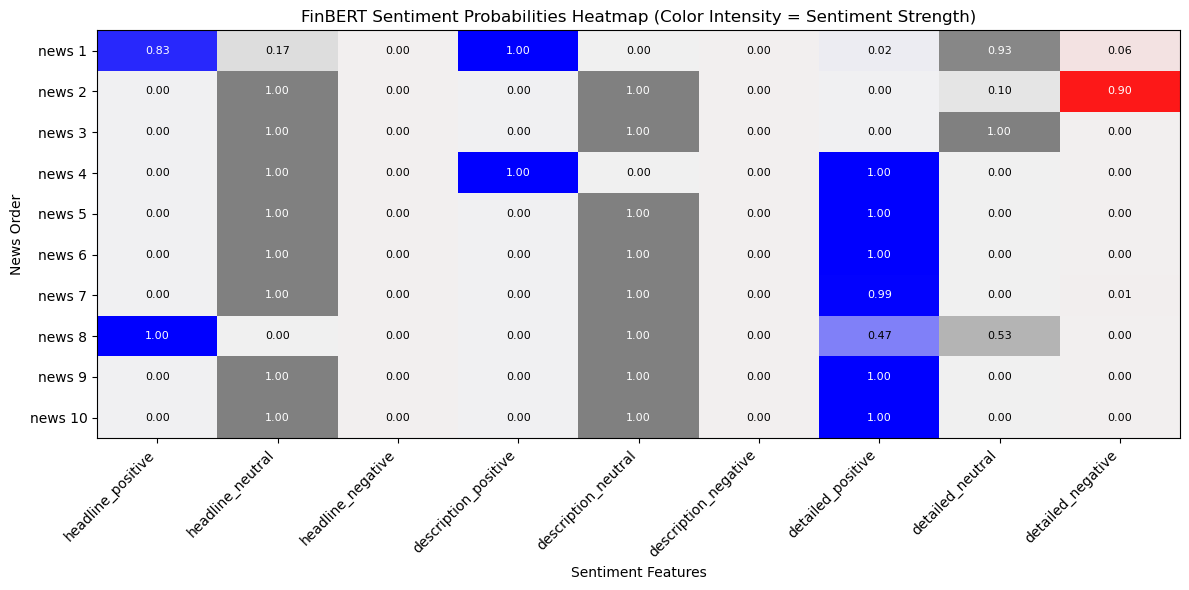

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sütunları sırayla: positive, neutral, negative (her üçlüde)
heatmap_cols = [
    "headline_positive", "headline_neutral", "headline_negative",
    "description_positive", "description_neutral", "description_negative",
    "detailed_positive", "detailed_neutral", "detailed_negative"
]
heatmap_data = df_with_probs[heatmap_cols]

# Her sentiment tipi için uygun renk paletleri
colormaps = {
    "positive": sns.light_palette("blue", as_cmap=True),
    "neutral": sns.light_palette("grey", as_cmap=True),
    "negative": sns.light_palette("red", as_cmap=True)
}

# Her sütun için uygun colormap seçimi
cmap_for_col = []
for col in heatmap_cols:
    if "positive" in col:
        cmap_for_col.append(colormaps["positive"])
    elif "neutral" in col:
        cmap_for_col.append(colormaps["neutral"])
    elif "negative" in col:
        cmap_for_col.append(colormaps["negative"])

# Tüm tabloyu tek bir heatmap olarak çiz
fig, ax = plt.subplots(figsize=(12, max(6, len(heatmap_data)//3)))

# Her sütun için ayrı renk paleti uygulamak için normalize edip RGB'ye çevir
normed = heatmap_data.values
rgb_array = np.zeros((normed.shape[0], normed.shape[1], 3))
for i, cmap in enumerate(cmap_for_col):
    # Her sütun için 0-1 arası normalize et
    col_vals = normed[:, i]
    rgb_array[:, i, :] = cmap(col_vals)[:, :3]  # RGBA'nın ilk 3'ü

# Görüntüyü göster
ax.imshow(rgb_array, aspect='auto')
ax.set_xticks(np.arange(len(heatmap_cols)))
ax.set_xticklabels(heatmap_cols, rotation=45, ha="right")
ax.set_yticks(np.arange(len(heatmap_data)))
ax.set_yticklabels([f"news {i+1}" for i in range(len(heatmap_data))])
ax.set_title("FinBERT Sentiment Probabilities Heatmap (Color Intensity = Sentiment Strength)")
ax.set_xlabel("Sentiment Features")
ax.set_ylabel("News Order")

# Skorları üstüne yazdır
for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        val = normed[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black" if val < 0.7 else "white", fontsize=8)

plt.tight_layout()
plt.show()

In [30]:
def classify_condition(row):
    # Use the highest probability among positive, neutral, negative
    pos = row['detailed_positive']
    neu = row['detailed_neutral']
    neg = row['detailed_negative']
    if pos >= 0.7:
        return "Highly Optimistic"
    elif pos >= 0.4:
        return "Optimistic"
    elif neg >= 0.7:
        return "Highly Pessimistic"
    elif neg >= 0.4:
        return "Pessimistic"
    else:
        return "Neutral"

df_with_probs['classified'] = df_with_probs.apply(classify_condition, axis=1)

# Yeni DataFrame oluştur
result_df = pd.DataFrame({
    "ticker": ticker,
    "news_header": df_with_probs["headline"],
    "news_description": df_with_probs["description"],
    "news_detail": df_with_probs["detailed_news"],
    "positive_score": df_with_probs["detailed_positive"],
    "neutral_score": df_with_probs["detailed_neutral"],
    "negative_score": df_with_probs["detailed_negative"],
    "classified": df_with_probs["classified"]
})

result_df.head()

,ticker,news_header,news_description,news_detail,positive_score,neutral_score,negative_score,classified
0,MSFT,How Microsoft plays both 'offense and defense',Microsoft's (MSFT) recent climb is a result of...,Microsoft's (MSFT) recent climb is a result of...,0.0166,0.9265,0.0569,Neutral
1,MSFT,The 2025 stock market rally is about more than...,After two years of few S&P 500 companies outpe...,This is The Takeaway from today's Morning Brie...,0.0001,0.1047,0.8952,Highly Pessimistic
2,MSFT,Analysis-Meta's $14.8 billion Scale AI deal la...,(Reuters) -Facebook owner Meta's $14.8 billion...,By Jody Godoy\n(Reuters) -Facebook owner Meta'...,0.0016,0.9984,0.0000,Neutral
3,MSFT,Cisco Stock: Three Reasons To Watch This Nvidi...,Boosted by demand for data centers and AI part...,Boosted by demand for data centers and AI part...,1.0000,0.0000,0.0000,Highly Optimistic
4,MSFT,AMD Stock Trades Higher Than Industry at 5.63X...,Advanced Micro Devices faces near-term headwin...,Advanced Micro DevicesAMD shares are currently...,1.0000,0.0000,0.0000,Highly Optimistic


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gokay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,ticker,news_header,news_description,news_detail,positive_score,neutral_score,negative_score,classified
0,AAPL,The 2025 stock market rally is about more than...,After two years of few S&P 500 companies outpe...,This is The Takeaway from today's Morning Brie...,0.0001,0.1047,0.8952,Highly Pessimistic
1,AAPL,Why Apple (AAPL) Dipped More Than Broader Mark...,Apple (AAPL) reached $196.45 at the closing of...,Apple (AAPL) closed at $196.45 in the latest t...,0.0000,1.0000,0.0000,Neutral
2,AAPL,Apple's $4.4B India Play: The Secret iPhone Sh...,"As Trump targets China, Apple quietly reroutes...",Apple (NASDAQ:AAPL) isrampingup its India prod...,0.0027,0.9908,0.0065,Neutral
3,AAPL,Spotify Widens Lead As Go-To Music App,A new survey shows that Spotify is widening it...,A new survey shows that Spotify is widening it...,0.0000,1.0000,0.0000,Neutral
4,AAPL,Trump Seeks to Register His Name for Mobile Ph...,"(Bloomberg) -- DTTM Operations LLC, the entity...","(Bloomberg) -- DTTM Operations LLC, the entity...",0.0000,1.0000,0.0000,Neutral


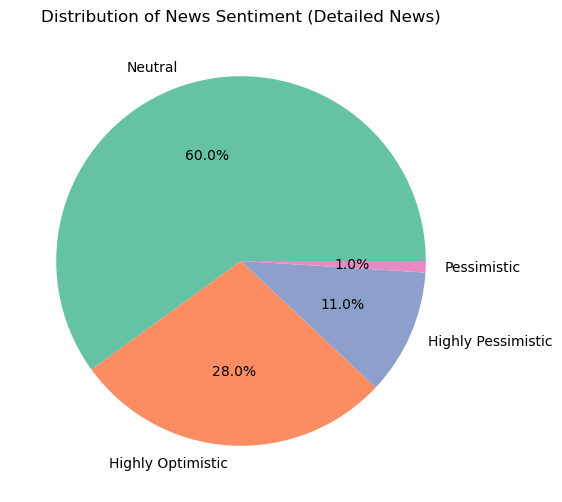

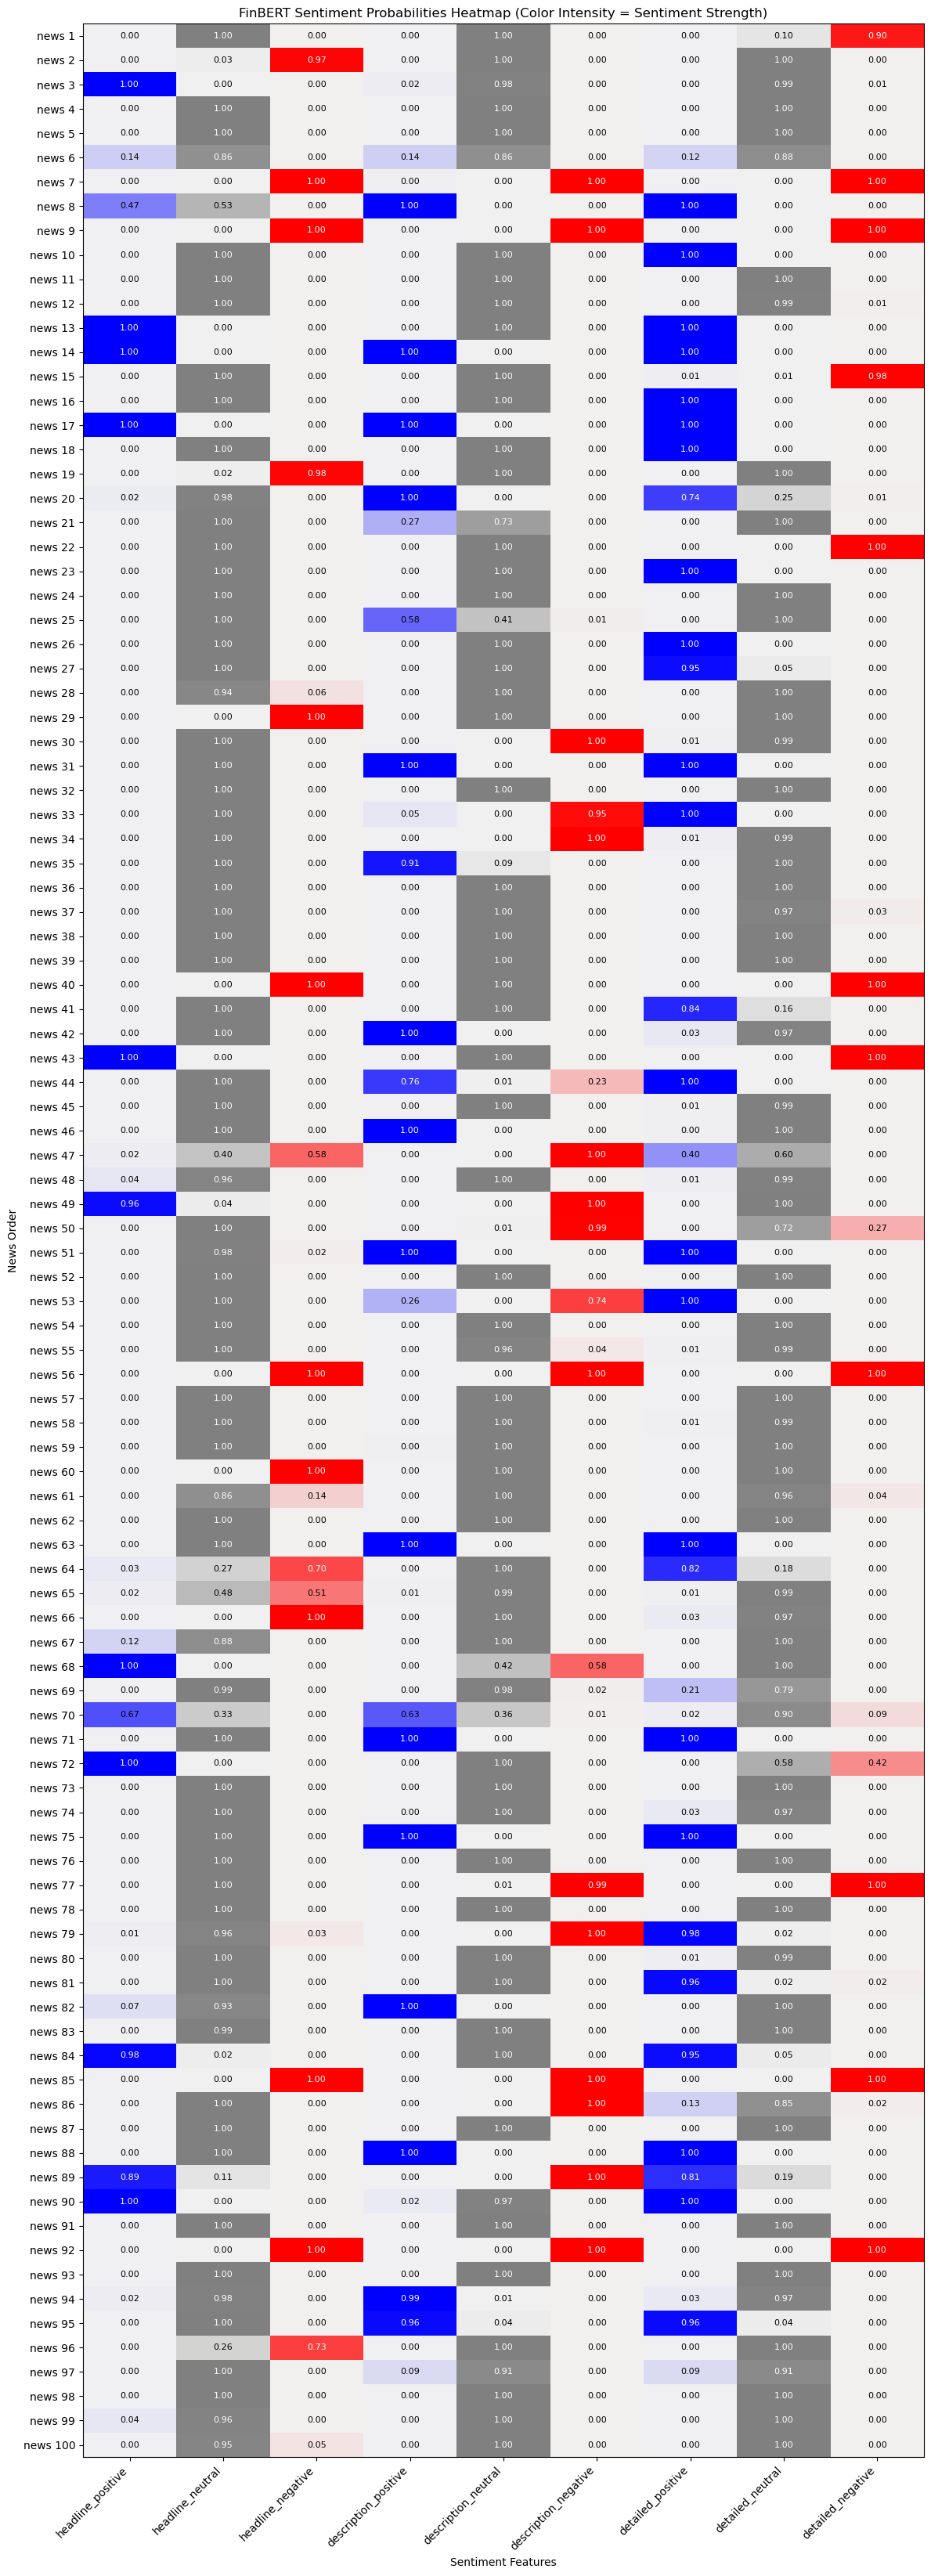

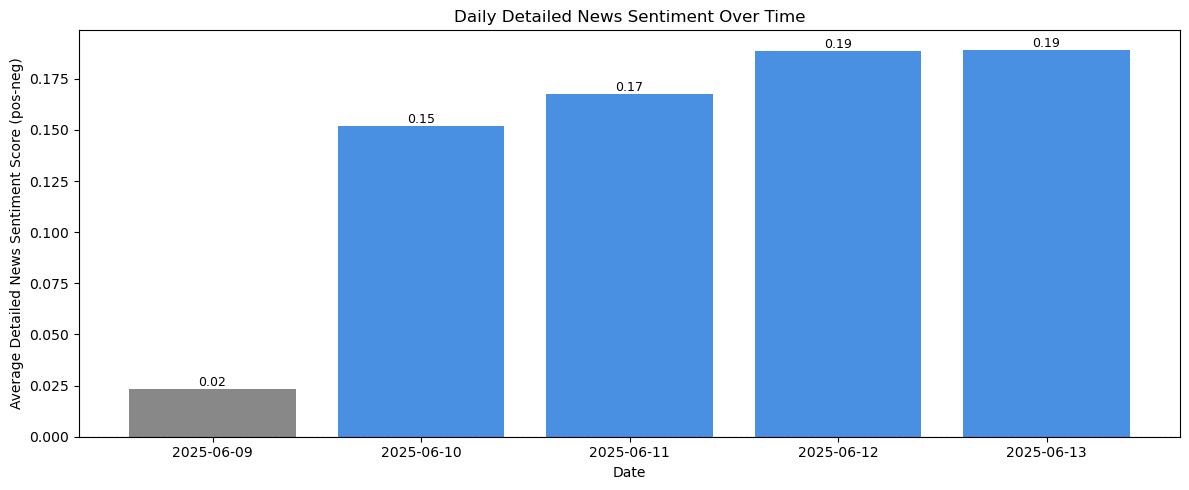

In [48]:
# 1. Install and import requirements
!pip install transformers torch nltk --quiet

import pandas as pd
import numpy as np
import torch
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.tokenize import sent_tokenize

# 2. Download NLTK punkt data
nltk.download('punkt')

# 3. Load FinBERT model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_model.to(device)
finbert_model.eval()

# 4. Load your news data
df = pd.read_csv("./aapl_news_from_html.csv")  # Change path as needed

# 5. FinBERT sentiment analysis function
def finbert_analyze(text):
    if not isinstance(text, str) or not text.strip():
        return {"sentiment": "neutral", "probabilities": {"neutral": 1.0, "positive": 0.0, "negative": 0.0}}
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = finbert_model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()[0]
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=0).numpy()
    labels = ['neutral', 'positive', 'negative']
    sentiment = labels[np.argmax(probs)]
    return {
        "sentiment": sentiment,
        "probabilities": dict(zip(labels, probs.round(4)))
    }

# 6. Extract only ticker/company-related sentences
def extract_ticker_sentences(text, ticker, company_names=None):
    if not isinstance(text, str) or not text.strip():
        return ""
    patterns = [rf"\b{ticker}\b"]
    if company_names:
        patterns += [re.escape(name) for name in company_names]
    pattern = re.compile("|".join(patterns), re.IGNORECASE)
    sentences = sent_tokenize(text)
    filtered = [s for s in sentences if pattern.search(s)]
    return " ".join(filtered) if filtered else ""

# 7. Row-wise analysis for ticker
def analyze_full_row_ticker(row, ticker, company_names=None):
    head_text = extract_ticker_sentences(row['headline'], ticker, company_names)
    desc_text = extract_ticker_sentences(row['description'], ticker, company_names)
    detail_text = extract_ticker_sentences(row['detailed_news'], ticker, company_names)
    head_result = finbert_analyze(head_text)
    desc_result = finbert_analyze(desc_text)
    detail_result = finbert_analyze(detail_text)
    head_probs = head_result['probabilities']
    desc_probs = desc_result['probabilities']
    detail_probs = detail_result['probabilities']
    return pd.Series({
        "headline_positive": head_probs['positive'],
        "headline_neutral": head_probs['neutral'],
        "headline_negative": head_probs['negative'],
        "description_positive": desc_probs['positive'],
        "description_neutral": desc_probs['neutral'],
        "description_negative": desc_probs['negative'],
        "detailed_positive": detail_probs['positive'],
        "detailed_neutral": detail_probs['neutral'],
        "detailed_negative": detail_probs['negative'],
    })

# 8. Apply analysis for MSFT
ticker = "AAPL"
company_names = ["Apple", "Apple Inc.", "AAPL"]  # Add variations of the company name
probs_df = df.apply(lambda row: analyze_full_row_ticker(row, ticker, company_names), axis=1)
df_with_probs = pd.concat([df, probs_df], axis=1)

# 9. Classify news condition by detailed news scores
def classify_condition(row):
    pos = row['detailed_positive']
    neg = row['detailed_negative']
    if pos >= 0.7:
        return "Highly Optimistic"
    elif pos >= 0.4:
        return "Optimistic"
    elif neg >= 0.7:
        return "Highly Pessimistic"
    elif neg >= 0.4:
        return "Pessimistic"
    else:
        return "Neutral"

df_with_probs['classified'] = df_with_probs.apply(classify_condition, axis=1)

# 10. Create final result DataFrame
result_df = pd.DataFrame({
    "ticker": ticker,
    "news_header": df_with_probs["headline"],
    "news_description": df_with_probs["description"],
    "news_detail": df_with_probs["detailed_news"],
    "positive_score": df_with_probs["detailed_positive"],
    "neutral_score": df_with_probs["detailed_neutral"],
    "negative_score": df_with_probs["detailed_negative"],
    "classified": df_with_probs["classified"]
})

display(result_df.head())

# 11. PIE CHART: Distribution of classified news
plt.figure(figsize=(6, 6))
result_df['classified'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette("Set2"), ylabel="")
plt.title("Distribution of News Sentiment (Detailed News)")
plt.show()



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sütunları sırayla: positive, neutral, negative (her üçlüde)
heatmap_cols = [
    "headline_positive", "headline_neutral", "headline_negative",
    "description_positive", "description_neutral", "description_negative",
    "detailed_positive", "detailed_neutral", "detailed_negative"
]
heatmap_data = df_with_probs[heatmap_cols]

# Her sentiment tipi için uygun renk paletleri
colormaps = {
    "positive": sns.light_palette("blue", as_cmap=True),
    "neutral": sns.light_palette("grey", as_cmap=True),
    "negative": sns.light_palette("red", as_cmap=True)
}

# Her sütun için uygun colormap seçimi
cmap_for_col = []
for col in heatmap_cols:
    if "positive" in col:
        cmap_for_col.append(colormaps["positive"])
    elif "neutral" in col:
        cmap_for_col.append(colormaps["neutral"])
    elif "negative" in col:
        cmap_for_col.append(colormaps["negative"])

# Tüm tabloyu tek bir heatmap olarak çiz
fig, ax = plt.subplots(figsize=(12, max(6, len(heatmap_data)//3)))

# Her sütun için ayrı renk paleti uygulamak için normalize edip RGB'ye çevir
normed = heatmap_data.values
rgb_array = np.zeros((normed.shape[0], normed.shape[1], 3))
for i, cmap in enumerate(cmap_for_col):
    # Her sütun için 0-1 arası normalize et
    col_vals = normed[:, i]
    rgb_array[:, i, :] = cmap(col_vals)[:, :3]  # RGBA'nın ilk 3'ü

# Görüntüyü göster
ax.imshow(rgb_array, aspect='auto')
ax.set_xticks(np.arange(len(heatmap_cols)))
ax.set_xticklabels(heatmap_cols, rotation=45, ha="right")
ax.set_yticks(np.arange(len(heatmap_data)))
ax.set_yticklabels([f"news {i+1}" for i in range(len(heatmap_data))])
ax.set_title("FinBERT Sentiment Probabilities Heatmap (Color Intensity = Sentiment Strength)")
ax.set_xlabel("Sentiment Features")
ax.set_ylabel("News Order")

# Skorları üstüne yazdır
for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        val = normed[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black" if val < 0.7 else "white", fontsize=8)

plt.tight_layout()
plt.show()
# 12. BARPLOT: Daily sentiment distribution for each field and sentiment
import matplotlib.pyplot as plt
import numpy as np

# Ensure date column is datetime and create a date-only column
df_with_probs['date_published'] = pd.to_datetime(df_with_probs['date_published'], errors='coerce')
df_with_probs['date'] = df_with_probs['date_published'].dt.date

# Calculate daily overall detailed sentiment score
df_with_probs['detailed_score'] = df_with_probs['detailed_positive'] - df_with_probs['detailed_negative']

# For each day, get the average score
daily = df_with_probs.groupby('date').agg({
    'detailed_score': 'mean'
}).reset_index()

# Color mapping by score
def score_to_color(score):
    if score > 0.15:
        return "#4A90E2"  # blueish
    elif score < -0.15:
        return "#D0021B"  # reddish
    else:
        return "#888888"  # grey

colors = daily['detailed_score'].apply(score_to_color)

plt.figure(figsize=(12, 5))
bars = plt.bar(daily['date'].astype(str), daily['detailed_score'], color=colors)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Date")
plt.ylabel("Average Detailed News Sentiment Score (pos-neg)")
plt.title("Daily Detailed News Sentiment Over Time")

# Add value labels
for bar, score in zip(bars, daily['detailed_score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{score:.2f}", 
             ha='center', va='bottom' if score>=0 else 'top', color="black", fontsize=9)

plt.tight_layout()
plt.show()

In [47]:
df_with_probs.detailed_score

0    -0.8951
1     0.0000
2    -0.0038
3     0.0000
4     0.0000
       ...  
95    0.0000
96    0.0931
97    0.0000
98    0.0000
99    0.0000
Name: detailed_score, Length: 100, dtype: float64

In [ ]:
finbert_analyze("'Investing.com -- Wells Fargo expects software stocks to rebound in the second half of the year as macroeconomic concerns ease and enterprise technology budgets normalize, but recommends investors remain selective through the summer.\nIn a mid-year update, the bank said volatility marked the first half of 2025, with tech shares swinging sharply and investor frustration mounting over the slow contribution from artificial intelligence.The firm noted its coverage has broadly returned to end-2024 levels, despite gains in major indexes like the NASDAQ Composite and iShares Expanded Tech-Software Sector ETF (NYSE:IGV).\nA survey conducted by Wells Fargo pointed to weaker IT spending growth in the first half, up just 2% year-on-year, but highlighted continued resilience in cloud infrastructure, cybersecurity, and generative AI initiatives, particularly in customer service.Microsoft (NASDAQ:MSFT) emerged as the top vendor, with over half of respondents expecting to increase spend.\nAI revenue monetization remains limited across most of software, the note said, but activity in the data space is picking up, with new SaaS data platforms and acquisitions gaining momentum.Wells Fargo raised its price targets on Microsoft and Snowflake (NYSE:SNOW).\nThe bank sees better seasonal demand benefiting smaller-cap software names in the second half, and upgraded Kenvue (NYSE:KVUE) to Overweight and DocuSign (NASDAQ:DOCU) to Equal Weight, while downgrading Dayforce and GitLab.It continues to favor companies undergoing business model transitions, including SAP and Autodesk (NASDAQ:ADSK).\nWells Fargo upgraded Zscaler (NASDAQ:ZS) to Overweight and raised its price target to $385, citing the company’s potential to reach $5 billion in annual recurring revenue by fiscal 2027.The bank expects over 20% billings growth in fiscal 2026 and sees margin expansion continuing alongside revenue growth.Zscaler’s shares, it said, remain undervalued relative to peers like CrowdStrike (NASDAQ:CRWD).\nRelated articles\nWells Fargo sees second-half rebound for software stocks, upgrades Zscaler\nBMO upgrades Oracle, sees double-digit income growth despite higher spending\nFord still struggling with rare earth supplies'")


{'sentiment': 'positive',
 'probabilities': {'neutral': 1e-04, 'positive': 0.9999, 'negative': 0.0}}